*This study was conducted for skills demonstration purposes only*

# **Forecasting the UK Construction Sector with Macroeconomic Indicators**
# Section 4. Exploratory Data Analysis (EDA)

In the previous sections, all necessary data was collected, cleaned, formatted, normalized, standardized and saved as df_final.csv, df_normalized_final.csv and df_standardized_final.csv. All outliers were processed. In this section final datasets will be analyzed and investigated for dependencies between indicators with data visualization methods.

### 1. Tools and Libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import seaborn as sns

### 2.  Auxiliary Functions

In [99]:
def create_subplot_trends(df, plots_dict, subtitle):
    """
    Creates subplots for multiple sets of time series data with key event markers.
    
    Parameters:
    - df: DataFrame with datetime index and event marker columns.
    - plots_dict: Dictionary where keys are subplot titles and values are [col_list, label_list, color_list].
    - suptitle: Title for the entire figure.
    """
    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Detect event dates
    def get_event_date(column, first=True):
        try:
            idx = df[df[column] == 1].index
            return idx[0] if first else idx[-1]
        except IndexError:
            return None

    first_lockdown = get_event_date('COVID_Lockdown')
    start_crisis = get_event_date('financial_crisis_2008', first=True)
    end_crisis = get_event_date('financial_crisis_2008', first=False)
    brexit = get_event_date('brexit_referendum_2016')

    events = [
        (first_lockdown, "COVID Lockdown"),
        (start_crisis, "2008 Crisis Start"),
        (end_crisis, "2008 Crisis End"),
        (brexit, "Brexit Referendum")
    ]

    # Setup figure and subplots
    n_plots = len(plots_dict)
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 5 * n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]

    for ax, (plot_title, (col_list, label_list, color_list)) in zip(axes, plots_dict.items()):
        # Plot lines
        for col, label, color in zip(col_list, label_list, color_list):
            ax.plot(df.index, df[col], label=label, color=color)

        # Add event markers
        ymin, ymax = ax.get_ylim()
        gap = timedelta(days=150)
        for date, label in events:
            if date:
                ax.axvline(x=date, color='red', linestyle='--', linewidth=1)
                ax.text(date - gap, (ymin + ymax) / 2, label, color='red',
                        rotation=90, verticalalignment='bottom', horizontalalignment='left', fontsize=10)

        # Styling
        ax.set_title(plot_title, fontsize=14)
        ax.set_ylabel('Normalized')
        ax.grid(True)
        ax.legend()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.tick_params(axis='x', rotation=45)

    axes[-1].set_xlabel("Date")
    fig.suptitle(subtitle, fontsize=16, y=0.990)
    plt.tight_layout()
    plt.show()


In [100]:
def create_subplot_new_contr(plots_dict, subtitle):
    """
    Creates vertically stacked area chart subplots with optional line overlays.

    Parameters:
    - plots_dict: dict
        Keys are subplot titles. Values are lists in the form:
            [df, col_area_list, area_label_list,
             col_line_list (optional), line_label_list (optional), line_color_list (optional)]
    - subtitle: str
        Overall title for the entire figure.
    """
    n_subplots = len(plots_dict)
    fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(15, 5 * n_subplots), squeeze=False)

    for i, (title, components) in enumerate(plots_dict.items()):
        df = components[0].copy()
        col_area_list = components[1]
        area_label_list = components[2]
        col_line_list = components[3] if len(components) > 3 else []
        line_label_list = components[4] if len(components) > 4 else []
        line_color_list = components[5] if len(components) > 5 else []

        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        ax = axes[i, 0]

        # Custom stacked area chart using fill_between
        color_palette = plt.get_cmap('Accent').colors
        area_colors = color_palette[:len(col_area_list)]
        stacked = np.zeros(len(df))

        for col, label, color in zip(col_area_list, area_label_list, area_colors):
            values = df[col].fillna(0).values
            ax.fill_between(df.index, stacked, stacked + values, label=label, color=color, alpha=0.7, linewidth=0.5)
            stacked += values

        # Mark key events
        gap = timedelta(days=150)
        ymin, ymax = ax.get_ylim()

        def draw_event_line(date, label):
            if pd.notna(date):
                ax.axvline(x=date, color='red', linestyle='--', linewidth=1)
                ax.text(date - gap, (ymin + ymax) / 2, label, color='black',
                        rotation=90, verticalalignment='center', horizontalalignment='left', fontsize=10)

        try:
            draw_event_line(pd.to_datetime(df[df['COVID_Lockdown'] == 1].index[0]), 'COVID Lockdown')
        except IndexError:
            pass
        try:
            draw_event_line(pd.to_datetime(df[df['financial_crisis_2008'] == 1].index[0]), 'Financial crisis 2008 start')
            draw_event_line(pd.to_datetime(df[df['financial_crisis_2008'] == 1].index[-1]), 'Financial crisis 2008 end')
        except IndexError:
            pass
        try:
            draw_event_line(pd.to_datetime(df[df['brexit_referendum_2016'] == 1].index[0]), 'Brexit referendum')
        except IndexError:
            pass

        # Optional line overlays (use ax.plot to avoid converter warnings)
        if col_line_list:
            for col, label, color in zip(col_line_list, line_label_list, line_color_list):
                ax.plot(df.index, df[col], label=label, color=color, linewidth=1)

        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Date')
        ax.set_ylabel('Normalized')
        ax.legend()

    fig.suptitle(subtitle, fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### 3. Loading data

In [101]:
#Reading data
df = pd.read_csv('df_final.csv').set_index('Date')
df_normalized = pd.read_csv('df_normalized_final.csv').set_index('Date')
df_standardized = pd.read_csv('df_standardized_final.csv').set_index('Date')

In [102]:
df

,CPIH,"GDP, £m","Employment rate, %","BoE Rate, %",GBP/EUR,GBP/USD,"Business Investment, % change","Govt Expenditure, £m","Construction output, £m","Construction Material Price Index, 2015 = 100",...,"New Contracts - Infrastructure, £m","New contracts - Other, £m","New Contracts - Private Industrial, £m","New Contracts - Private Commercial, £m","New contracts - All Construction, £m",COVID_Lockdown,HS2_contracts,Commercial_Construction_Boom_2006,financial_crisis_2008,brexit_referendum_2016
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,78.3,167567.33,73.2,4.7500,1.4331,1.8764,-0.17,48114,14699.33,70.53,...,545.00,866.00,412.67,1908.00,5216.33,0,0,0,0,0
2005-02-01,78.5,167567.33,73.1,4.7500,1.4499,1.8871,-0.17,46543,14699.33,70.53,...,545.00,866.00,412.67,1908.00,5216.33,0,0,0,0,0
2005-03-01,78.8,167567.33,72.9,4.7500,1.4440,1.9078,-0.17,46066,14699.33,70.53,...,545.00,866.00,412.67,1908.00,5216.33,0,0,0,0,0
2005-04-01,79.1,168968.67,72.9,4.7500,1.4652,1.8960,18.53,49028,14592.67,70.53,...,552.67,906.00,548.33,1860.33,5508.33,0,0,0,0,0
2005-05-01,79.4,168968.67,72.9,4.7500,1.4611,1.8538,18.53,42293,14592.67,70.53,...,552.67,906.00,548.33,1860.33,5508.33,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,133.5,213891.67,74.9,5.0000,1.1903,1.3217,0.73,106042,17692.00,153.00,...,728.33,443.00,336.00,987.00,3184.33,0,0,0,0,0
2024-10-01,134.3,214095.67,74.9,5.0000,1.1972,1.3045,-0.63,108156,17684.00,152.20,...,505.33,456.67,271.67,992.33,3066.67,0,0,0,0,0
2024-11-01,134.6,214095.67,75.0,4.7976,1.1998,1.2750,-0.63,102631,17795.00,152.90,...,505.33,456.67,271.67,992.33,3066.67,0,0,0,0,0


In [103]:
df.columns

Index(['CPIH', 'GDP, £m', 'Employment rate, %', 'BoE Rate, %', 'GBP/EUR',
       'GBP/USD', 'Business Investment, % change', 'Govt Expenditure, £m',
       'Construction output, £m',
       'Construction Material Price Index, 2015 = 100',
       'Small construction companies', 'Medium construction companies',
       'Large construction companies', 'Number of all construction companies',
       'Employees - Small construction companies',
       'Employees - Medium construction companies',
       'Employees - Large construction companies',
       'Employees - All construction companies',
       'New Contracts - Public Housing, £m',
       'New Contracts - Private Housing, £m',
       'New Contracts - Infrastructure, £m', 'New contracts - Other, £m',
       'New Contracts - Private Industrial, £m',
       'New Contracts - Private Commercial, £m',
       'New contracts - All Construction, £m', 'COVID_Lockdown',
       'HS2_contracts', 'Commercial_Construction_Boom_2006',
       'financial_

In [104]:
df_normalized.columns

Index(['CPIH_normalized', 'GDP, £m_normalized',
       'Employment rate, %_normalized', 'BoE Rate, %_normalized',
       'GBP/EUR_normalized', 'GBP/USD_normalized',
       'Business Investment, % change_normalized',
       'Govt Expenditure, £m_normalized', 'Construction output, £m_normalized',
       'Construction Material Price Index, 2015 = 100_normalized',
       'Small construction companies_normalized',
       'Medium construction companies_normalized',
       'Large construction companies_normalized',
       'Number of all construction companies_normalized',
       'Employees - Small construction companies_normalized',
       'Employees - Medium construction companies_normalized',
       'Employees - Large construction companies_normalized',
       'Employees - All construction companies_normalized',
       'New Contracts - Public Housing, £m_normalized',
       'New Contracts - Private Housing, £m_normalized',
       'New Contracts - Infrastructure, £m_normalized',
       'New 

### 4. Summary Statistics

In [105]:
df.describe(include='all')

,CPIH,"GDP, £m","Employment rate, %","BoE Rate, %",GBP/EUR,GBP/USD,"Business Investment, % change","Govt Expenditure, £m","Construction output, £m","Construction Material Price Index, 2015 = 100",...,"New Contracts - Infrastructure, £m","New contracts - Other, £m","New Contracts - Private Industrial, £m","New Contracts - Private Commercial, £m","New contracts - All Construction, £m",COVID_Lockdown,HS2_contracts,Commercial_Construction_Boom_2006,financial_crisis_2008,brexit_referendum_2016
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,...,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,100.966805,189175.954398,73.378008,1.848834,1.227438,1.510454,0.287510,71867.136929,15073.572697,106.327967,...,727.420290,665.263029,354.959419,1316.774938,4231.192033,0.008299,0.012448,0.012448,0.082988,0.004149
std,14.656190,15125.145355,1.802560,2.052024,0.118365,0.236099,2.805218,17006.170211,1638.469761,24.536197,...,258.792608,233.873856,132.577818,495.188665,810.147283,0.090908,0.111105,0.111105,0.276438,0.064416
min,78.300000,160589.670000,70.100000,0.100000,1.086700,1.130700,-10.730000,42293.000000,9218.000000,70.530000,...,336.670000,319.670000,149.330000,551.000000,2010.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.900000,175678.000000,72.200000,0.500000,1.144700,1.298500,-0.630000,63517.000000,13861.000000,88.800000,...,553.330000,488.330000,256.330000,1021.670000,3720.330000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.900000,187898.000000,73.300000,0.500000,1.178900,1.507600,0.170000,68077.000000,14889.330000,101.200000,...,699.330000,622.000000,343.000000,1124.000000,4127.330000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,108.500000,203217.670000,75.000000,4.500000,1.264600,1.634500,1.170000,78037.000000,16472.000000,112.200000,...,817.000000,834.670000,426.330000,1353.000000,4442.670000,0.000000,0.000000,0.000000,0.000000,0.000000
max,135.100000,215611.000000,76.500000,5.750000,1.507900,2.070100,18.530000,115625.000000,17881.000000,162.700000,...,2204.670000,1342.000000,713.000000,2813.000000,6095.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 5. Correlation Heatmap

For the correlation heatmap the dataset with standartized data 'df_standardized' will be used because it scales all variables to a mean of 0 and standard deviation of 1, ensuring equal contribution regardless of original units (e.g., £m, %, indices). This aligns with Pearson correlation assumptions, providing accurate and comparable linear relationships across diverse columns.

In [106]:
#Check the columns list
df_standardized.columns

Index(['CPIH_standardized', 'GDP, £m_standardized',
       'Employment rate, %_standardized', 'BoE Rate, %_standardized',
       'GBP/EUR_standardized', 'GBP/USD_standardized',
       'Business Investment, % change_standardized',
       'Govt Expenditure, £m_standardized',
       'Construction output, £m_standardized',
       'Construction Material Price Index, 2015 = 100_standardized',
       'Small construction companies_standardized',
       'Medium construction companies_standardized',
       'Large construction companies_standardized',
       'Number of all construction companies_standardized',
       'Employees - Small construction companies_standardized',
       'Employees - Medium construction companies_standardized',
       'Employees - Large construction companies_standardized',
       'Employees - All construction companies_standardized',
       'New Contracts - Public Housing, £m_standardized',
       'New Contracts - Private Housing, £m_standardized',
       'New Contracts

Due to the long list of columns, the heat map will be split into two parts for better visibility: 'Strong Correlations (|r| > 0.5): Macroeconomic vs Construction Indicators' and 'Weak Correlations (|r| <= 0.5): Macroeconomic vs Construction Indicators'.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#1. Define column groups
macro_cols = df_standardized.columns[:8]          # 8 macro indicators
construction_cols = df_standardized.columns[8:25] # 17 construction indicators

#2. Compute 8x17 correlation matrix
correlation = pd.DataFrame(index=macro_cols, columns=construction_cols)

for macro in macro_cols:
    for constr in construction_cols:
        correlation.loc[macro, constr] = df_standardized[macro].corr(df_standardized[constr])

correlation = correlation.astype(float)

#3. Clean axis names
correlation.index = [
    name.split(',')[0] if ',' in name else name.split('_standardized')[0]
    for name in correlation.index
]
correlation.columns = [
    'Construction output', 'Constr Material Price Index',
    'Small', 'Medium', 'Large', 'All',
    'in Small firms', 'in Medium firms', 'in Large firms', 'in All firms',
    'Public Housing', 'Private Housing', 'Infrastructure', 'Other',
    'Private Industrial', 'Private Commercial', 'All Construction'
]

#4. Define group info
group_boundaries = [2, 6, 10]
group_ranges = [(0, 2), (2, 6), (6, 10), (10, 17)]
group_colors = ['#F0F0F0', '#E6F0FA', '#E8F5E9', '#FFF3E0']
group_labels = ['Number of Companies', 'Number of Employees', 'Number of New Contracts']
group_label_ranges = [(2, 6), (6, 10), (10, 17)]

#5. Heatmap plotting function
def plot_correlation_heatmap(corr_matrix, title, mask_strong=False):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(18, 8))

    # Create mask and display matrix
    if mask_strong:
        mask = corr_matrix.abs() > 0.6
        display_matrix = corr_matrix.where(~mask)
    else:
        display_matrix = corr_matrix.where(corr_matrix.abs() >= 0.6)
        mask = None

    # Plot heatmap
    ax = sns.heatmap(
        display_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        cbar_kws={"label": "Correlation"},
        linewidths=0.5,
        linecolor='gray',
        annot_kws={"color": "black"},
        alpha=0.5 if mask_strong else 1.0  # Light color for weak correlations
    )

    # Add vertical group dividers
    for boundary in group_boundaries:
        ax.axvline(x=boundary, color='#555555', linewidth=2)

    # Set background color for x-tick labels
    for i, (start, end) in enumerate(group_ranges):
        for j in range(start, end):
            if j < len(ax.get_xticklabels()):
                ax.get_xticklabels()[j].set_backgroundcolor(group_colors[i])

    # Add group labels above heatmap
    for (start, end), label in zip(group_label_ranges, group_labels):
        x_center = (start + end) / 2
        ax.text(x_center, -0.2, label, ha='center', va='bottom', fontsize=13)

    # Adjust tick spacing and padding
    ax.tick_params(axis='x', pad=5)
    plt.title(title, fontsize=18, pad=60)
    plt.xlabel("Construction Indicators", fontsize=15)
    plt.ylabel("Macroeconomic Indicators", fontsize=15, labelpad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.show()


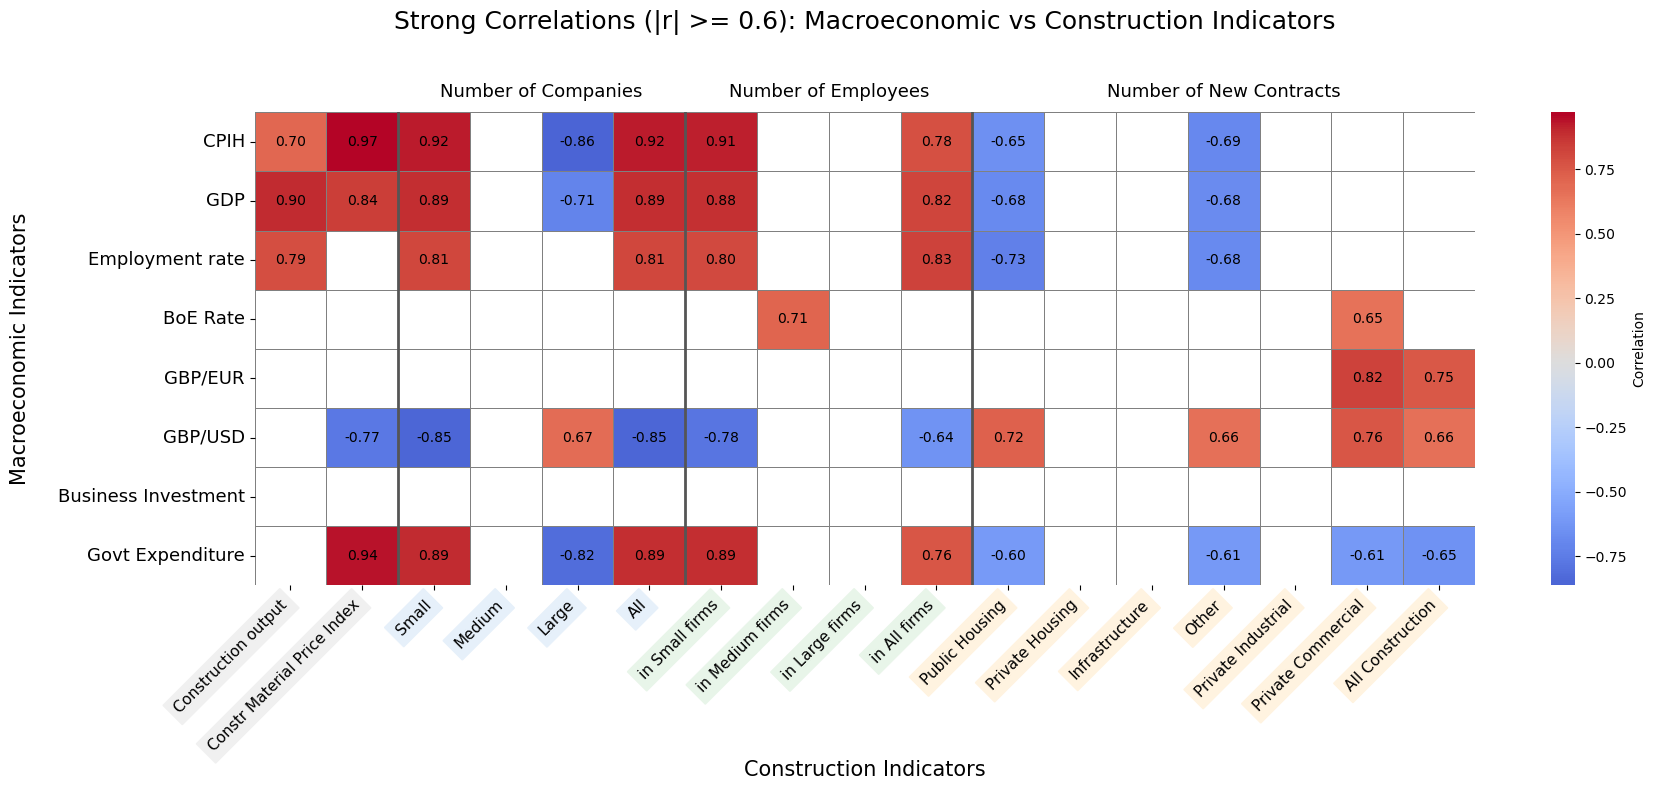

In [108]:
# Plot a heatmap for strong correlations
plot_correlation_heatmap(
    correlation,
    title="Strong Correlations (|r| >= 0.6): Macroeconomic vs Construction Indicators",
    mask_strong=False
)

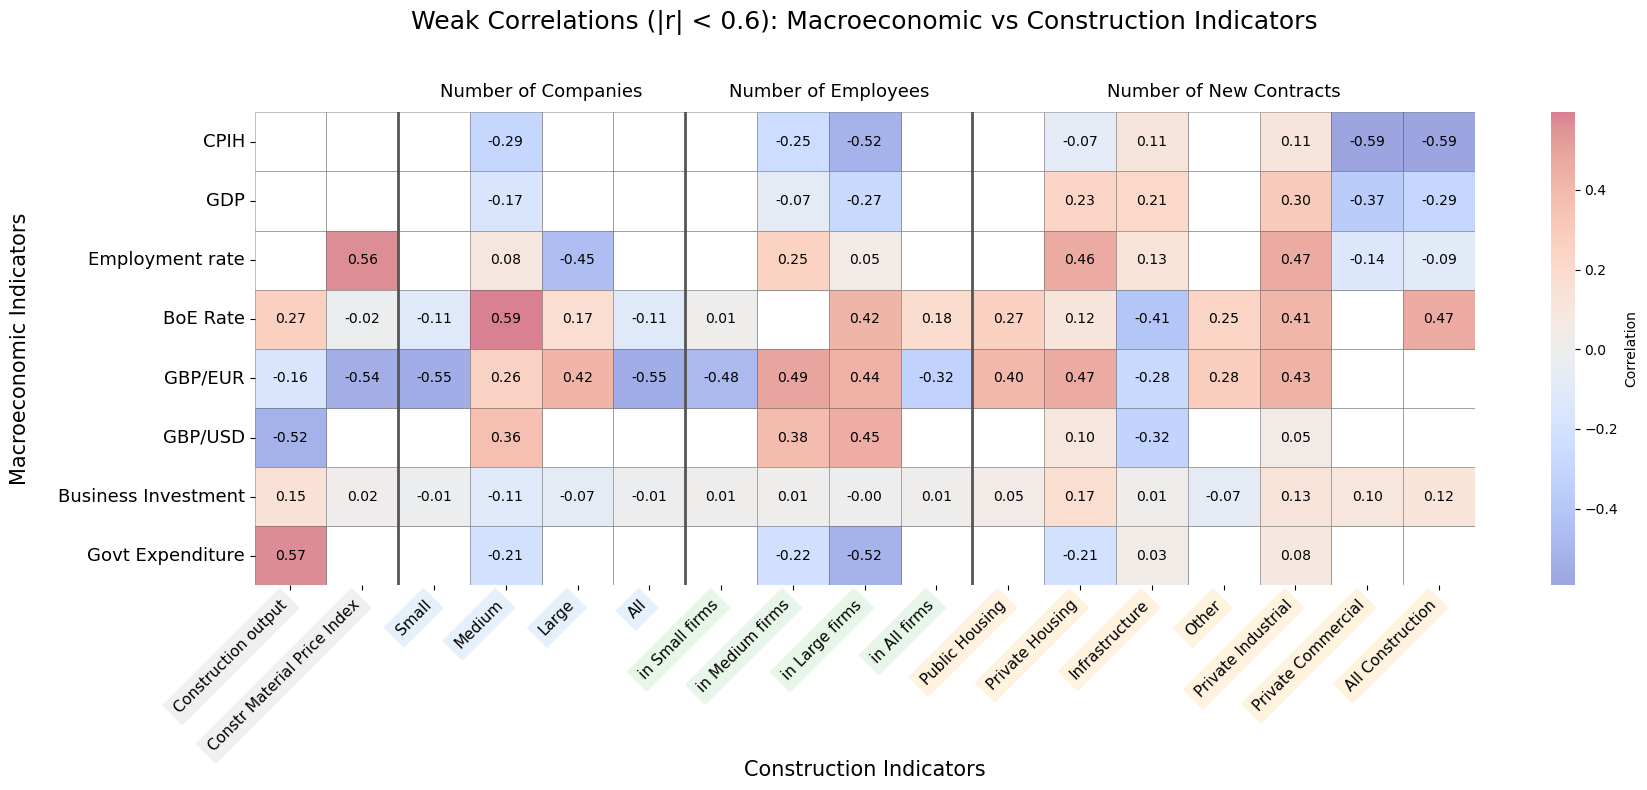

In [109]:
# Plot a heatmap fpr weak correlations
plot_correlation_heatmap(
    correlation,
    title="Weak Correlations (|r| < 0.6): Macroeconomic vs Construction Indicators",
    mask_strong=True
)

### Correlation Insights Table

The following table summarizes key insights from the correlation heatmaps between macroeconomic indicators (CPIH, GDP, Employment rate, BoE Rate, GBP/EUR, GBP/USD, Business Investment, Government Expenditure) and construction sector indicators (2005–2025), highlighting relationships, implications, time-lag effects, and their relevance to the research questions.

| **Construction Indicator Category** | **Key Correlations** | **Insights and Implications** | **Potential Time-Lag Effects** | **Research Implications** |
| --- | --- | --- | --- | --- |
| **Construction Output** | GDP (0.90), Employment rate (0.79), CPIH (0.70), GBP/USD (-0.52) | Strong positive correlations with GDP and Employment rate confirm construction’s cyclical nature. Negative GBP/USD correlation suggests a stronger pound increases material costs, reducing output. | Lagged GDP effects (3–6 months) may amplify correlations, as economic growth drives construction with delays. | GDP and Employment rate will be tested as leading indicators for forecasting output using Granger causality. |
| **Construction Material Price Index** | CPIH (0.97), Govt Expenditure (0.94), GBP/USD (-0.77) | Near-perfect correlation with CPIH and strong link to Govt Expenditure show material prices track inflation and public spending. Negative GBP/USD correlation indicates imported material costs rise with a stronger pound. | Inflation lags (3–12 months) may strengthen price correlations, as material costs adjust gradually. | CPIH and Govt Expenditure will be used in lagged regression to forecast material prices. |
| **Small Firms & Total Employees** | CPIH (0.78–0.92), GDP (0.82–0.89), Employment rate (0.81–0.83), GBP/USD (-0.64–0.85) | Small firms and total employment thrive during economic booms and high inflation, but a stronger pound reduces activity due to cost pressures. | Lagged economic growth (6–12 months) may enhance correlations, as small firms scale with demand. | Small firms’ sensitivity to economic cycles will be analyzed for sub-sector forecasting. |
| **Medium & Large Firms/Employees** | CPIH (-0.13 to -0.87), GDP (-0.03 to -0.71), BoE Rate (0.42–0.70) | Weak/negative correlations with CPIH and GDP suggest larger firms face cost pressures or consolidation during economic growth. Unexpected positive BoE Rate correlation may reflect anticipatory investments. | Positive BoE Rate correlations may turn negative with lags (3–6 months) as borrowing costs impact larger firms. | Divergent responses of medium/large firms will be investigated using VAR models. |
| **New Contracts (Public Housing, Other, All)** | CPIH (-0.59 to -0.65), GDP (-0.29 to -0.68), Employment rate (-0.09 to -0.73) | Negative correlations indicate high economic growth or inflation delays new projects due to rising costs or capacity constraints. | Lagged GDP/CPIH effects (6–12 months) may reveal positive correlations as projects initiate post-cost stabilization. | Impact of economic shocks (e.g., Brexit) on contract delays will be analyzed. |
| **New Contracts (Private Commercial)** | GBP/EUR (0.82), GBP/USD (0.76), BoE Rate (0.65) | Strong positive correlations with exchange rates and BoE Rate suggest commercial projects benefit from a stronger pound (foreign investment) and higher rates (anticipatory financing). | Lagged BoE Rate effects (3–6 months) may show negative correlations as borrowing costs deter projects. | Foreign investment’s role in commercial contracts will be analyzed using regression. |
| **New Contracts (Infrastructure, Private Industrial)** | CPIH (0.11), GDP (0.21–0.30), BoE Rate (-0.41 to 0.41) | Weak correlations suggest these sub-sectors are less sensitive to economic cycles, possibly due to long-term contracts or stable demand. | Minimal lag effects expected, but cross-correlation analysis can confirm if weak relationships strengthen over time. | Infrastructure’s stability will be analyzed. |


The correlation heatmaps reveals strong ties between construction output, small firms, and macroeconomic indicators (GDP, CPIH, Employment rate), confirming the sector’s cyclical nature. Material prices track inflation and public spending. Medium and large firms and new contracts show unexpected patterns, probably due to time lags (3–12 months). These insights directly address research questions on correlations, predictive modeling, time lags, sub-sector impacts, and black swan events.

### 6. Analyzing Individual Indicators Patterns Using Visualization

#### 6.1 UK Economic Trends with Key Events

Before analyzing construction indicators, let's familiarize yourself with UK macroeconomic trends and key events.

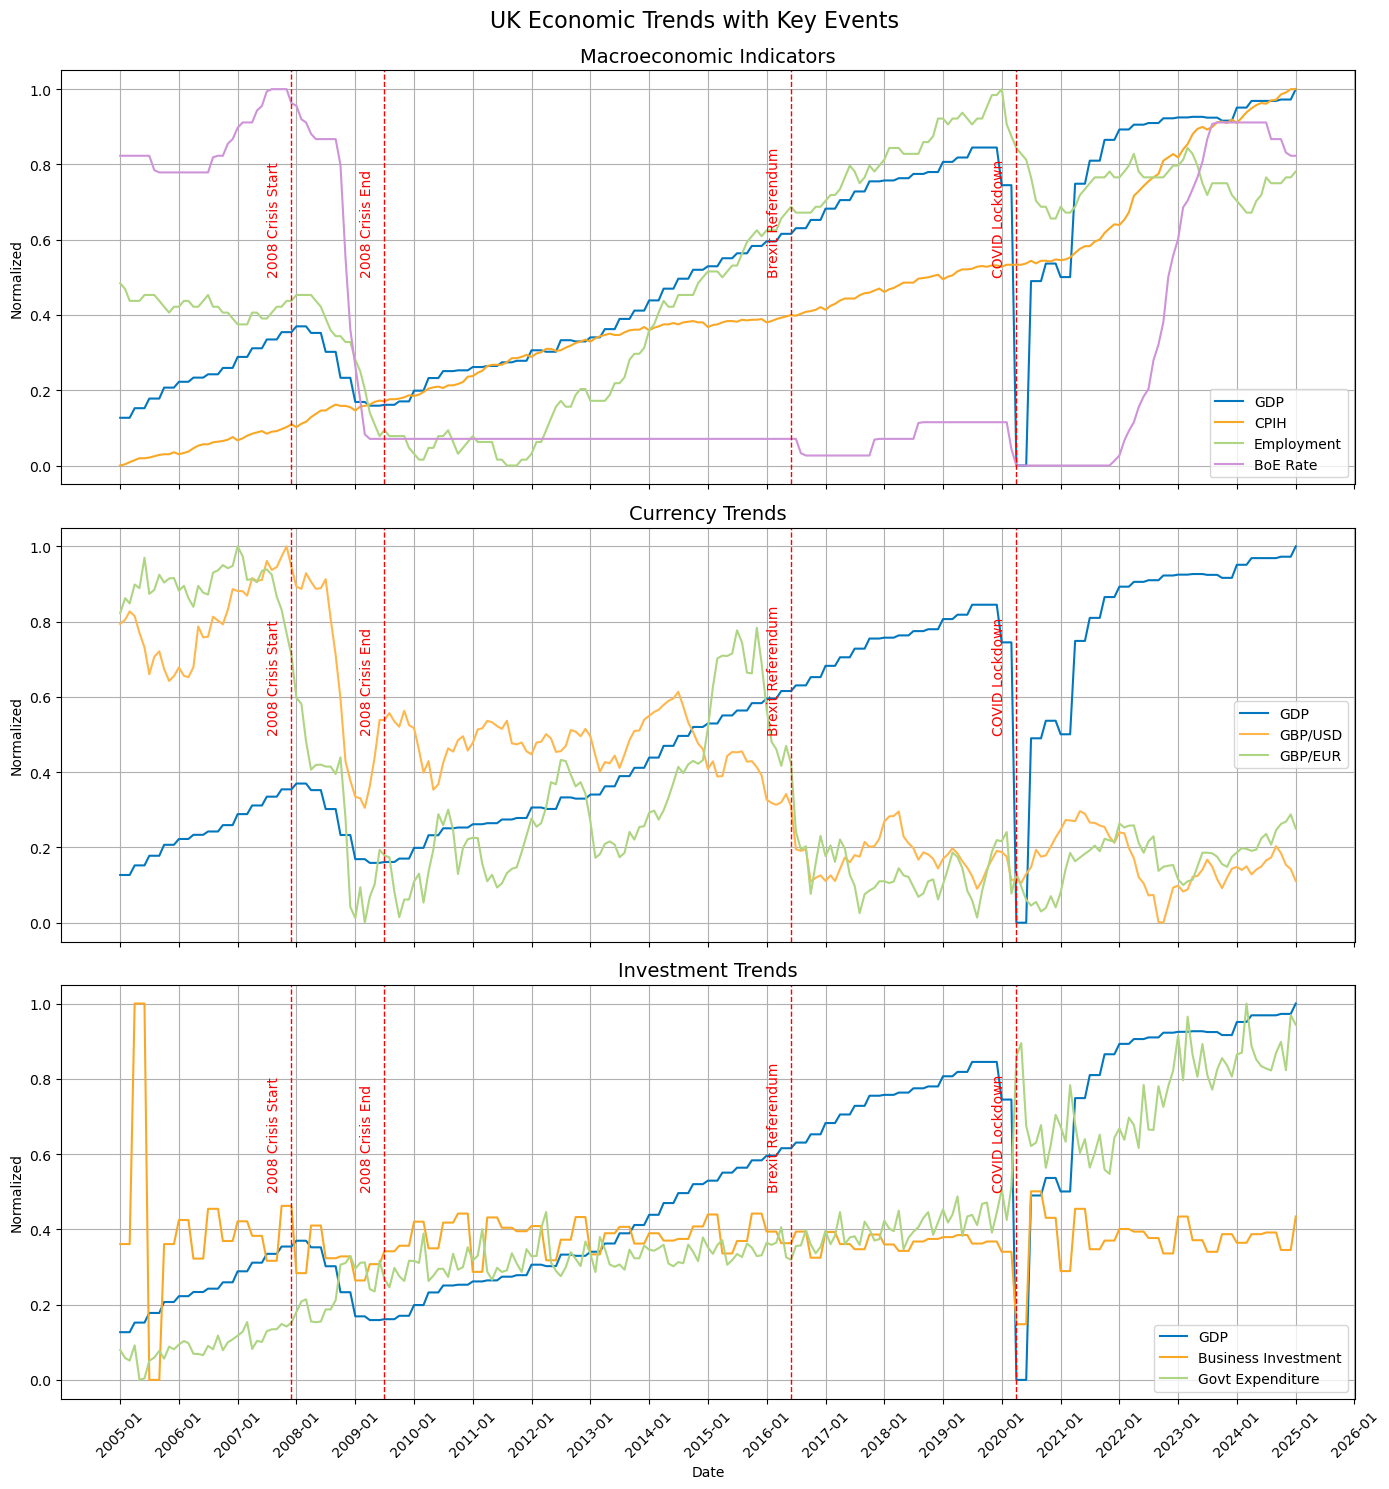

In [110]:
# Creating subplots for UK Economic Trends with Key Events using auxiliary function
plots_dict = {
    "Macroeconomic Indicators": [
        ['GDP, £m_normalized', 'CPIH_normalized', 'Employment rate, %_normalized', 'BoE Rate, %_normalized'],
        ['GDP', 'CPIH', 'Employment', 'BoE Rate'],
        ['#0277bd', '#f9a825', '#aed581', '#ce93d8']
    ],
    "Currency Trends": [
        ['GDP, £m_normalized', 'GBP/USD_normalized', 'GBP/EUR_normalized'],
        ['GDP', 'GBP/USD', 'GBP/EUR'],
        ['#0277bd', '#ffb74d', '#aed581']
    ],
    "Investment Trends": [
        ['GDP, £m_normalized', 'Business Investment, % change_normalized', 'Govt Expenditure, £m_normalized'],
        ['GDP', 'Business Investment', 'Govt Expenditure'],
        ['#0277bd', '#f9a825', '#aed581']
    ]
}

create_subplot_trends(df_normalized, plots_dict, subtitle="UK Economic Trends with Key Events")

- The 2008 financial crisis and the COVID-19 lockdown caused significant declines in UK GDP, as seen across all three subplots. While the 2008 recovery was gradual, GDP rebounded quickly after the initial COVID shock, reflecting strong short-term resilience.

- CPIH remained relatively stable throughout most major events, suggesting inflation was not immediately driven by these crises, though longer-term pressures may have developed.

- The employment rate dropped sharply during the COVID-19 period, revealing the labor market’s sensitivity to abrupt shocks. However, its movement during the 2008 crisis was more gradual.

- BoE interest rates were slashed during both the 2008 and COVID-19 periods, highlighting the central bank’s use of monetary policy to stabilize the economy.

- Currency depreciation following the Brexit referendum and during the COVID crisis indicates reduced investor confidence. This has implications for import costs and inflation over time.

- Business investment showed a consistent pattern of decline during crisis periods, while government expenditure increased most significantly in response to COVID-19 — underscoring the state’s role in stabilizing the economy.

- Overall, the data reveal a pattern of economic vulnerability to shocks, followed by varying recovery speeds depending on the nature of the event and the policy response.

#### 6.2 Trends in UK Construction Output and Materials Prices

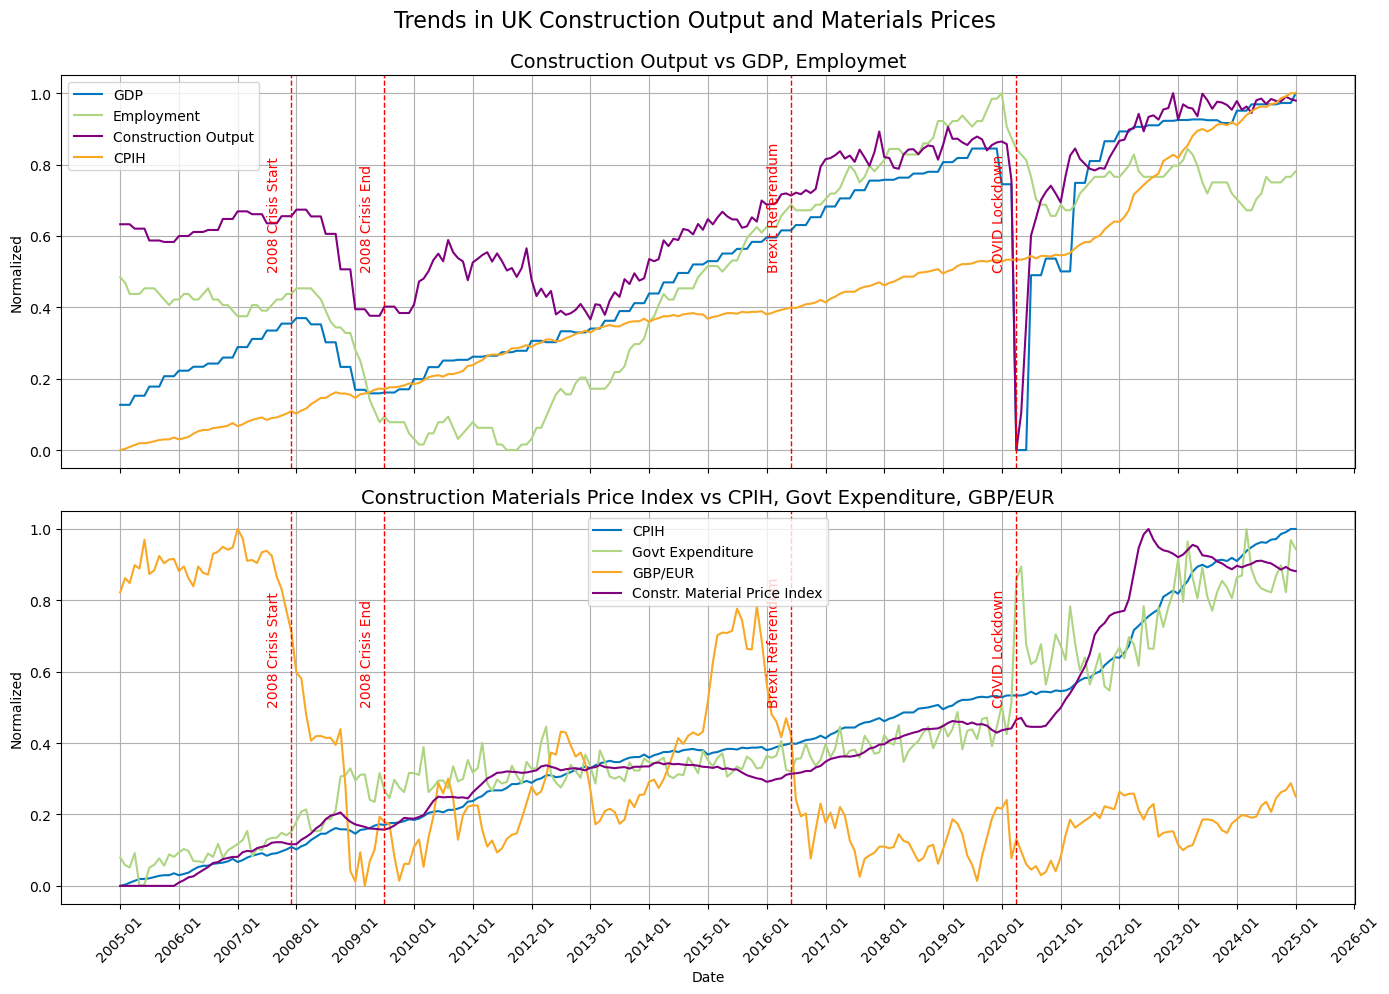

In [111]:
# Creating subplots for Trends in UK Construction Output and Materials Prices using auxiliary function
plots_dict = {
    "Construction Output vs GDP, Employmet": 
    [
        ['GDP, £m_normalized', 'Employment rate, %_normalized', 'Construction output, £m_normalized', 'CPIH_normalized'], 
        ['GDP', 'Employment', 'Construction Output', 'CPIH'],
        ['#0277bd', '#aed581', 'purple', '#f9a825']
    ],
        "Construction Materials Price Index vs CPIH, Govt Expenditure, GBP/EUR": 
    [
        ['CPIH_normalized', 'Govt Expenditure, £m_normalized', 'GBP/EUR_normalized', 'Construction Material Price Index, 2015 = 100_normalized'], 
        ['CPIH', 'Govt Expenditure', 'GBP/EUR', 'Constr. Material Price Index'],
        ['#0277bd', '#aed581', '#f9a825', 'purple']
    ]
}

create_subplot_trends(df_normalized, plots_dict, subtitle="Trends in UK Construction Output and Materials Prices")

- Construction Output and GDP
  Convergence: Still evident — both plummet during 2008 crisis and COVID lockdown.
  Divergence: GDP lags slightly behind construction output post-2021.

- Material Prices and Currency (GBP/EUR)
  Convergence: Sharp material price increase post-Brexit, aligned with GBP depreciation.
  Divergence: In the 2022–2025 period, GBP/EUR stabilizes, but material prices remain elevated, implying additional inflationary pressures or supply constraints.

- Employment and Construction Output
  Convergence: Both fall during crises.
  Divergence: Post-2020, construction output recovers faster than employment, again suggesting labor market rigidities or mismatch.

- Govt Expenditure and Construction Output
  Convergence: Especially around 2020, surge in public spending seems followed by construction output rebound.
  Implication: Fiscal stimulus played a direct role in sectoral recovery.

- Interest Rates and Construction Output
  Historically aligned — output tends to increase after interest rate cuts, particularly visible after 2008 and 2020.

#### 6.2 Construction firms and economic trends

Small comapnies make up 99% of all construction companies, normalized data will be used to compare trends.

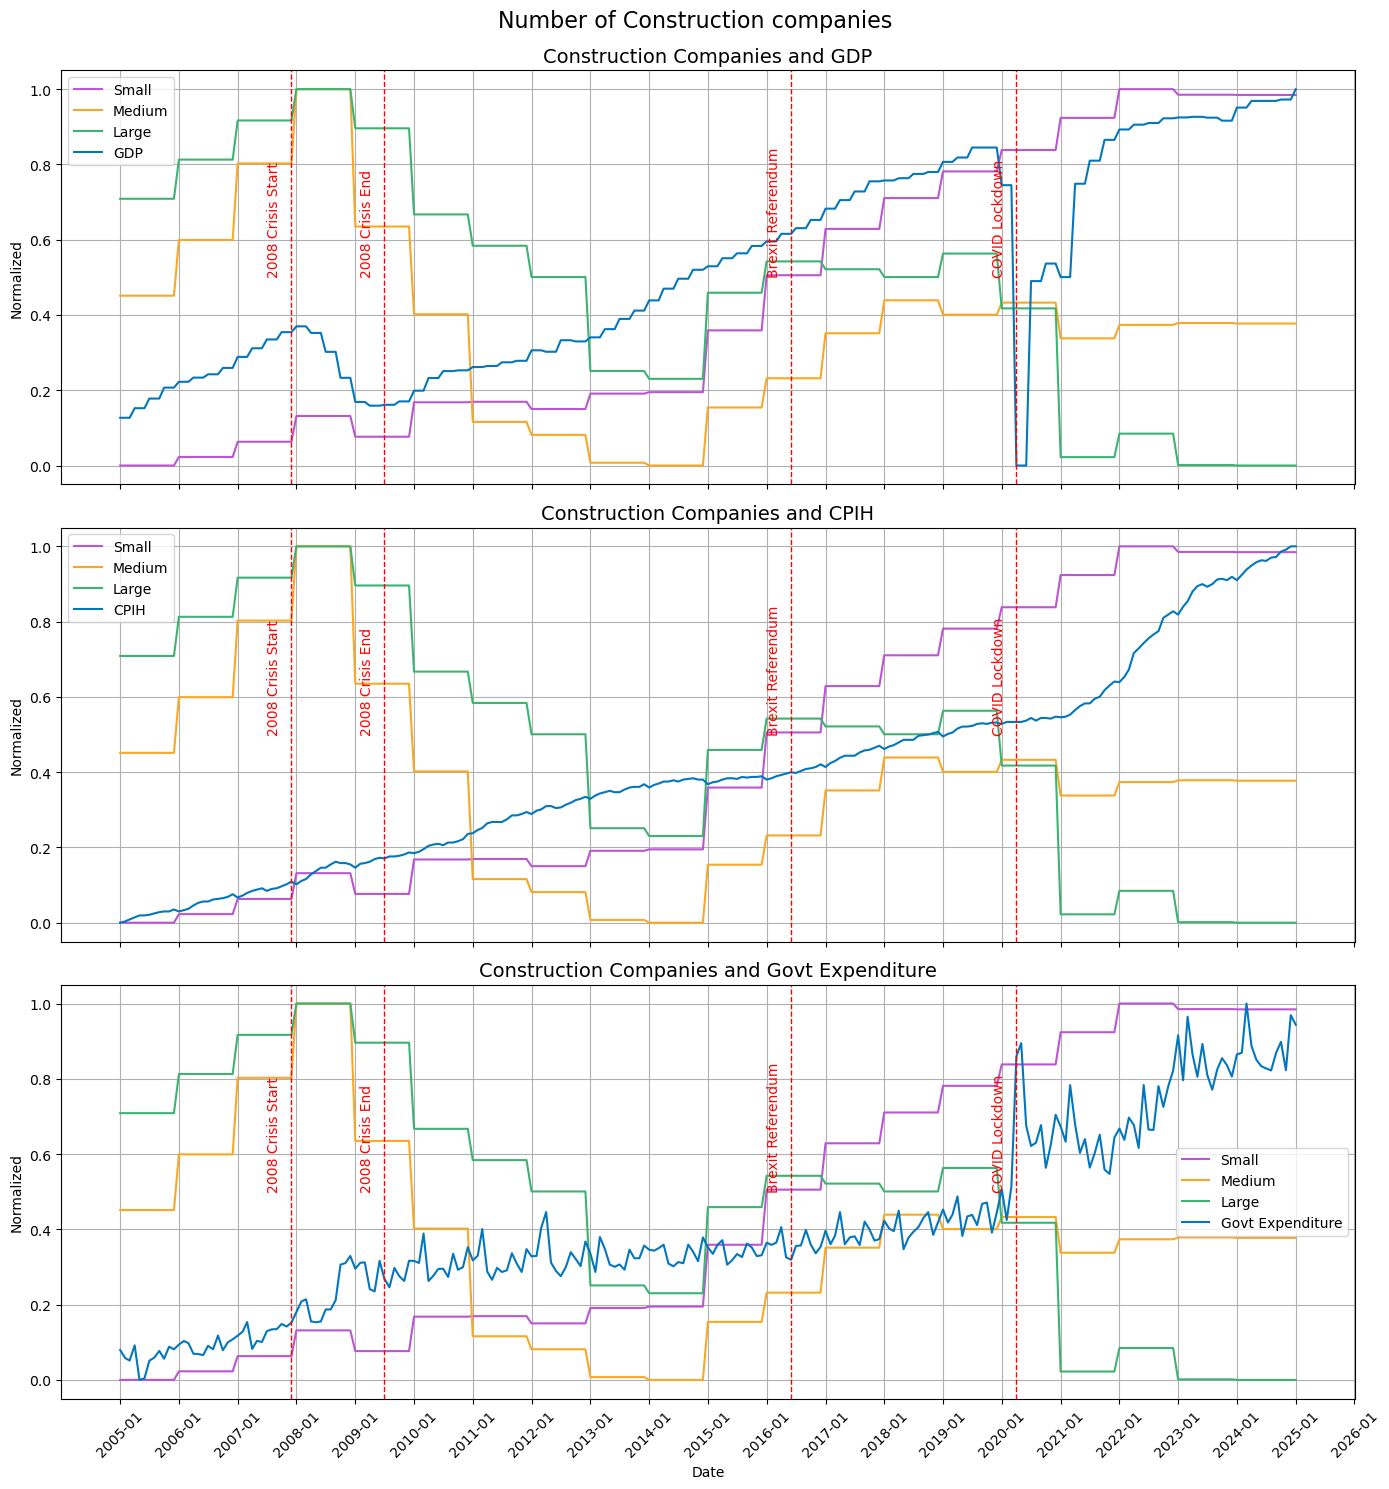

In [112]:
# Creating subplots for number of construction companies changes over time and Key economic Events
plots_dict = {
    "Construction Companies and GDP": [
        ['Small construction companies_normalized', 'Medium construction companies_normalized', 'Large construction companies_normalized', 'GDP, £m_normalized'],
        ['Small', 'Medium', 'Large', 'GDP'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ],
    "Construction Companies and CPIH": [
        ['Small construction companies_normalized', 'Medium construction companies_normalized', 'Large construction companies_normalized', 'CPIH_normalized'],
        ['Small', 'Medium', 'Large', 'CPIH'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ],
    "Construction Companies and Govt Expenditure": [
        ['Small construction companies_normalized', 'Medium construction companies_normalized', 'Large construction companies_normalized', 'Govt Expenditure, £m_normalized'],
        ['Small', 'Medium', 'Large', 'Govt Expenditure'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ]
}

create_subplot_trends(df_normalized, plots_dict, subtitle="Number of Construction companies")

**2008 Financial Crisis Impact**

- Small, medium, and large construction companies show stagnation or decline during the crisis.
- Post-crisis, small companies recover more visibly, while large firms decline gradually.

**Post-Brexit Divergence with CPIH**

- After the 2016 Brexit referendum, CPIH rises steadily.
- In contrast, the number of construction companies—especially medium and large—plateaus or decreases, implying inflation outpaces industry expansion.

**COVID-19 Lockdown Effects**

- Large construction companies decline sharply during early 2020, while small companies remain stable or even grow, suggesting smaller firms may have been more adaptable or less exposed
- Government expenditure spikes, suggesting stimulus support not immediately mirrored in firm recovery.

**Post-COVID Recovery and Resilience**

- Small companies show stable grow.
- Medium companies show slow recovery.
- Large firms show an attempt to recovery in 2022 but then continue to decline, indicating weaker resilience.

**2008 Crisis as a Converging Event**

- Small companies show quick recovery
- Medium and large companies continue to decline even after financial market recovery

**Divergence During Brexit and COVID**

- Government expenditure increases, while company counts stagnate or fall, indicating policy focus on macro-stabilization over direct industry stimulus.


#### 6.3 Employment trends in the UK construction industry

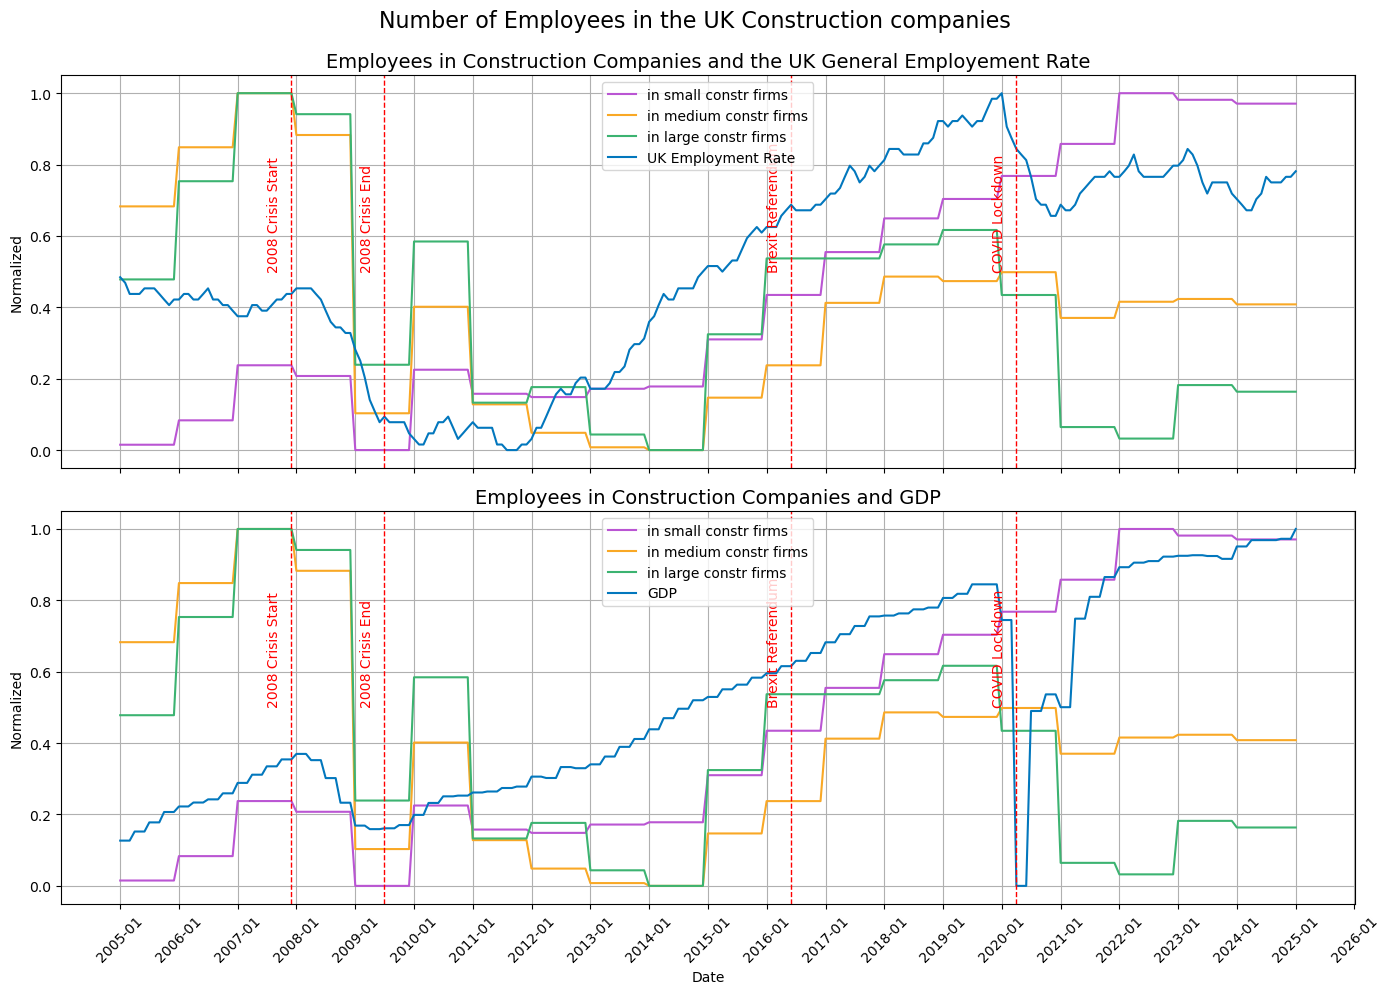

In [113]:
# Creating subplots for number of employees in construction companies over time and Key economic Events
plots_dict = {
    "Employees in Construction Companies and the UK General Employement Rate": [
        ['Employees - Small construction companies_normalized', 'Employees - Medium construction companies_normalized', 'Employees - Large construction companies_normalized', 'Employment rate, %_normalized'],
        ['in small constr firms ', 'in medium constr firms', 'in large constr firms', 'UK Employment Rate'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ],
    "Employees in Construction Companies and GDP": [
        ['Employees - Small construction companies_normalized', 'Employees - Medium construction companies_normalized', 'Employees - Large construction companies_normalized', 'GDP, £m_normalized'],
        ['in small constr firms ', 'in medium constr firms', 'in large constr firms', 'GDP'],
        ['#BA55D3', '#f9a825', '#3CB371', '#0277bd']
    ]
}

create_subplot_trends(df_normalized, plots_dict, subtitle="Number of Employees in the UK Construction companies")

- During the 2008 Financial Crisis, employment across all construction firm sizes declines significantly, with large firms dropping most sharply, suggesting their higher exposure to systemic shocks.

- The UK Employment Rate also drops during the crisis, but starts recovering post-2011, unlike construction employment, which remains subdued longer—indicating a slower recovery for the construction sector than the general labor market.

- Post-2010, employment in small firms gradually rises and becomes the leading contributor by 2020, indicating the growing importance of small firms in construction employment.

- Medium-sized firms show a plateau post-crisis and remain relatively stable until 2020, after which they stagnate—pointing to a lack of growth momentum in the medium segment.

- Employment in large construction firms remains volatile and does not recover to pre-crisis levels, especially post-2016, showing possible downsizing or structural shifts.

- Brexit (2016) seems to have minimal immediate impact on overall employment levels in construction firms, but a slight slowing in upward trends is noticeable.

- The COVID-19 Lockdown (2020) causes a noticeable dip in UK GDP and Employment Rate, but small construction firm employment levels appear largely unaffected. Medium ad Large firms employment show significant decline which was not fully restored.

- Post-COVID, employment in small construction firms continues to rise, reflecting a shift in sector dynamics where smaller firms are becoming key employers.

- The alignment between GDP and construction employment is more consistent than with the UK-wide employment rate, especially in the recovery phase—hinting that construction employment may track economic output more closely than general labor trends.

#### 6.4 New contracts trends in the UK construction industry
Before analyzing new contracts trends over time, let's familiarize yourself with each subsector percetage of all new contracts on 2025-01-01 .

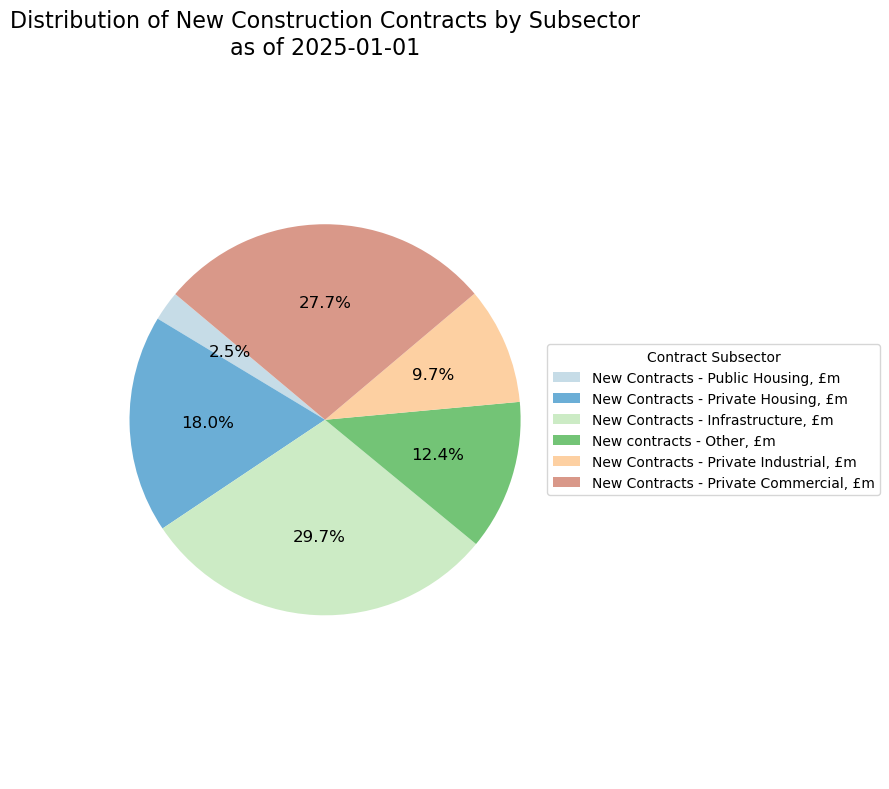

In [114]:
# Filter the data for the specific date
target_date = '2025-01-01'
row = df.loc[target_date, ['New Contracts - Public Housing, £m',
       'New Contracts - Private Housing, £m',
       'New Contracts - Infrastructure, £m', 'New contracts - Other, £m',
       'New Contracts - Private Industrial, £m',
       'New Contracts - Private Commercial, £m']]

# Define better-separated colors (6 distinct ones)
colors = [
    '#c6dce7',  # soft light blue
    '#6baed6',  # muted blue
    '#ccebc5',  # soft green
    '#73c476',  # muted green
    '#fdd0a2',  # peachy orange
    '#d99889'   # dusty red (less bright)
]

# Plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    row,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'color': 'black', 'fontsize': 12}
)
plt.legend(row.index, title='Contract Subsector', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('Distribution of New Construction Contracts by Subsector\nas of 2025-01-01', fontsize=16, pad=5)
plt.axis('equal')

plt.tight_layout()
plt.show()

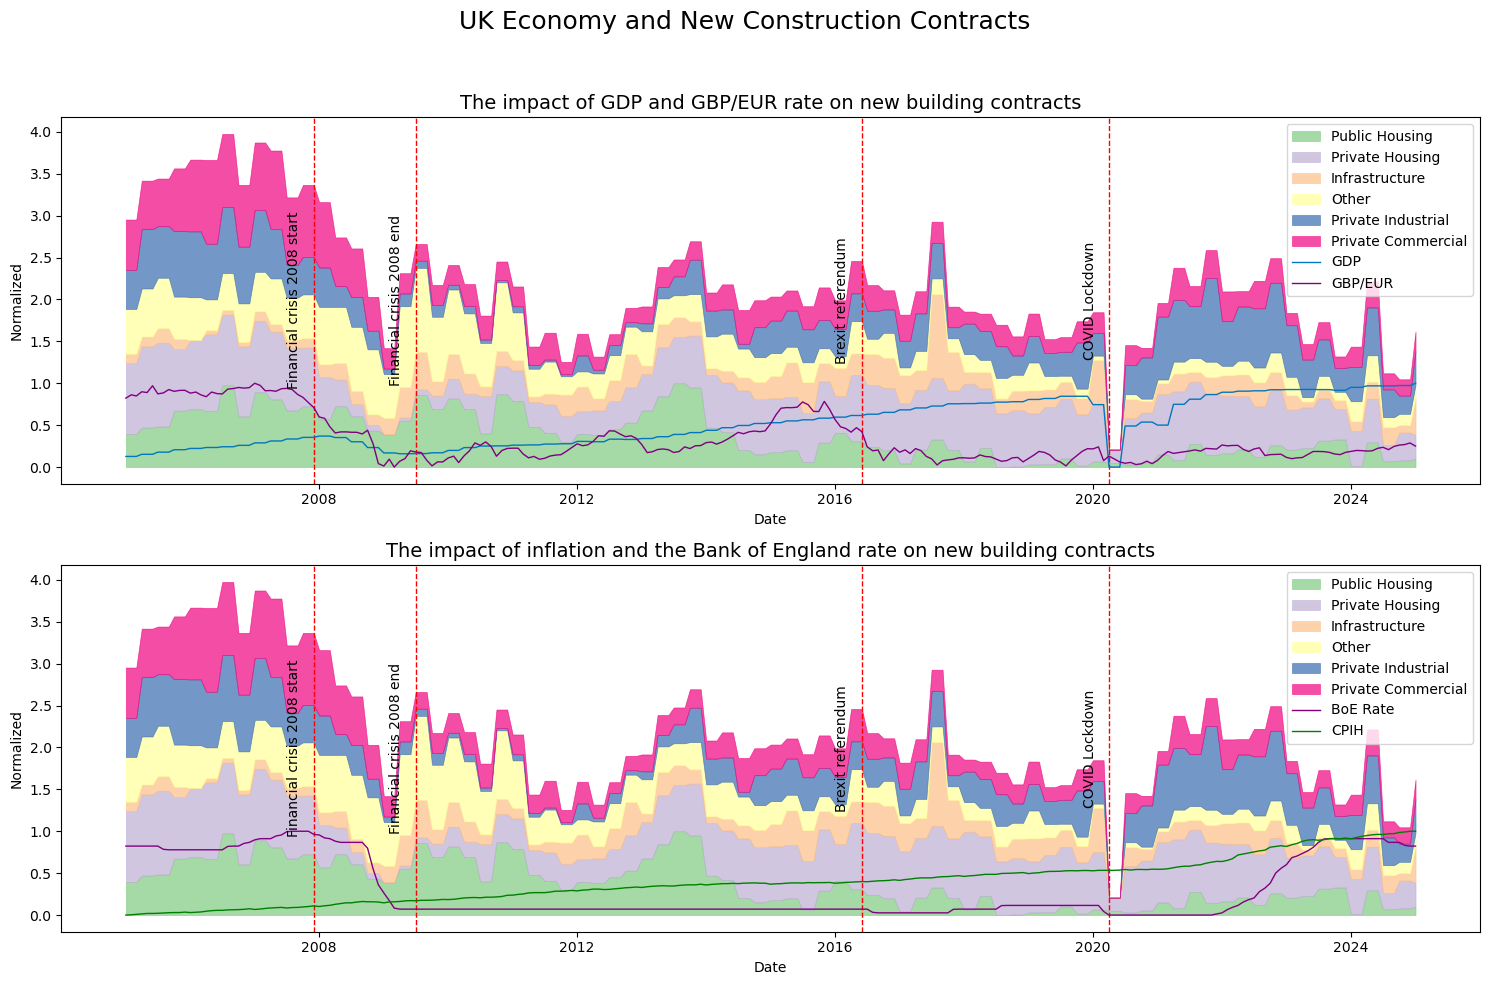

In [115]:
plots_dict = {
    'The impact of GDP and GBP/EUR rate on new building contracts':
    [
        df_normalized,
        [
            'New Contracts - Public Housing, £m_normalized',
           'New Contracts - Private Housing, £m_normalized',
           'New Contracts - Infrastructure, £m_normalized', 
            'New contracts - Other, £m_normalized',
           'New Contracts - Private Industrial, £m_normalized',
           'New Contracts - Private Commercial, £m_normalized'
        ], 
        [
            'Public Housing',
           'Private Housing',
           'Infrastructure', 
            'Other',
           'Private Industrial',
           'Private Commercial'
        ],
        ['GDP, £m_normalized', 'GBP/EUR_normalized'], ['GDP', 'GBP/EUR'], ['#0277bd', 'purple']
    ],
    'The impact of inflation and the Bank of England rate on new building contracts':
    [
        df_normalized,
        [
            'New Contracts - Public Housing, £m_normalized',
           'New Contracts - Private Housing, £m_normalized',
           'New Contracts - Infrastructure, £m_normalized', 
            'New contracts - Other, £m_normalized',
           'New Contracts - Private Industrial, £m_normalized',
           'New Contracts - Private Commercial, £m_normalized'
        ], 
        [
            'Public Housing',
           'Private Housing',
           'Infrastructure', 
            'Other',
           'Private Industrial',
           'Private Commercial'
        ],
        ['BoE Rate, %_normalized', 'CPIH_normalized'], ['BoE Rate', 'CPIH'], ['purple', 'green']
    ]
}

create_subplot_new_contr(plots_dict, subtitle = 'UK Economy and New Construction Contracts')

- During the 2008 financial crisis, new construction contracts across all sectors (public housing, private housing, infrastructure, etc.) dropped sharply, converging with a decline in GDP and GBP/EUR, reflecting a broad economic downturn.

- The Brexit referendum (2016) saw a temporary dip in contracts, converging with GBP/EUR decline, suggesting currency volatility impacted construction activity.

- Post-Brexit, infrastructure and other contracts diverged upward while GDP and CPIH remained stable, likely due to government stimulus or long-term project continuity.

- During the COVID-19 lockdown (2020), all contract types plummeted, converging with a GDP drop, indicating a widespread economic halt.
Post-lockdown, private housing and commercial contracts recovered more quickly, diverging from CPIH and GBP/EUR, possibly due to pent-up demand and policy support.

- Public housing contracts show a steady but lower trend, diverging from private sectors, which may reflect limited public funding compared to private investment.

- Overall, economic events drive convergence during downturns and divergence during recoveries, influenced by sector-specific resilience and policy responses.

## Time-Lag Insights: Macroeconomic Indicators and UK Construction Sector Trends

| Macroeconomic Indicator | Construction Indicator | Typical Lag Time | Notes on Observations and Events |
|------------------------|-----------------------|------------------|----------------------------------|
| GDP | Construction Output | 3–6 months | - During downturns (e.g., 2008 financial crisis, COVID-19), GDP declines precede construction output drops by 3–6 months, as seen in EDA subplots. <br> - **Post-2021 Exception**: Construction output led GDP recovery, likely due to stimulus or anticipatory investments, indicating a reverse lag. |
| CPIH (Inflation) | Construction Material Prices | 3–12 months | - CPIH increases lead material price hikes, with delays from supply chain adjustments, observed in the material prices subplot. <br> - Post-Brexit, prices remained elevated beyond CPIH stabilization, suggesting external pressures. |
| Employment Rate | Construction Employment | 6–12 months | - General employment rate declines are followed by construction employment drops, with slower recovery, as shown in employment trends subplot. <br> - Reflects sector-specific labor market dynamics. |
| Economic Conditions (GDP, CPIH) | New Construction Contracts | 6–12 months | - New contracts decline during shocks (e.g., COVID-19) and recover post-stabilization, per the new contracts subplot. <br> - Delays stem from project planning and financing timelines. |
| Currency (GBP/EUR, GBP/USD) | Construction Material Prices | 1–3 months | - Currency depreciation (e.g., post-Brexit, COVID-19) rapidly increases material prices due to import costs, as seen in currency and material prices subplots. |
| Currency (GBP/EUR, GBP/USD) | New Construction Contracts | 3–6 months | - Exchange rate shifts affect new contracts, particularly private commercial ones tied to foreign investment, per currency and contracts subplots. <br> - Investment decisions adjust more slowly. |

### Key Takeaways
- **Lag Range**: Time-lags span **1–12 months**, reflecting the construction sector’s delayed response to economic changes.
- **GDP and Output**: Typically a 3–6 month lag, with a notable post-2021 reversal where construction led GDP.
- **CPIH and Material Prices**: Inflation drives prices with a 3–12 month delay, amplified by Brexit effects.
- **Employment**: Construction employment lags broader trends by 6–12 months, recovering slowly.
- **New Contracts**: Economic conditions impact contracts with a 6–12 month delay due to planning.
- **Currency Effects**: Material prices react quickly (1–3 months) to currency changes, while contracts lag by 3–6 months.

These findings, grounded in the EDA’s visual analysis, support the development of time-lagged predictive models (e.g., VAR) for forecasting construction trends.

## Conclusion

The Exploratory Data Analysis (EDA) of the UK construction sector (2005–2025) revealed strong correlations between macroeconomic indicators and construction metrics, with GDP (0.90) and employment rate (0.79) driving output, and CPIH (0.97) and government expenditure (0.94) influencing material prices. Visual trends highlighted the sector’s sensitivity to economic shocks (e.g., 2008 crisis, COVID-19), with small firms showing resilience and material prices spiking post-Brexit. Time-lags of 1–12 months (e.g., 3–6 months for GDP to output, 1–3 months for currency to material prices) underscore delayed responses, informing predictive modeling and policy analysis.

### Authors

[Alisa Makhonina](https://www.linkedin.com/in/alisa-makhonina-data-science/) Data scientist with over 8 years of experience in construction cost engineering. Structural Engineering graduate.